In [1]:
import os
import pathlib

from config import *
os.chdir(PROJECT_ROOT_PATH)

import fitz
import json
import pandas as pd

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

import torchvision.models.detection.faster_rcnn.FasterRCNN

/home/f/Programming/projects/scans_to_pdf_cg_cv
/home/f/Programming/projects/scans_to_pdf_cg_cv/latex/playground2
/home/f/Programming/projects/scans_to_pdf_cg_cv/latex/content
/home/f/Programming/projects/scans_to_pdf_cg_cv/data
/home/f/Programming/projects/scans_to_pdf_cg_cv/model_states


In [2]:
DOCUMENT_PATH = pathlib.Path(LATEX_PLAYGROUND_PATH).joinpath('main.pdf')
COORDS_PATH = pathlib.Path(LATEX_PLAYGROUND_PATH).joinpath('coordslog.json')
PAGESIZE_PATH = pathlib.Path(LATEX_PLAYGROUND_PATH).joinpath('paperheight.txt')

In [3]:
def image_from_file(file_path):
    return np.array(Image.open(file_path).convert('L'))

def save_array_as_image(file_path, arr, target_shape=None):
    Path(file_path).parents[0].mkdir(parents=True, exist_ok=True)
    img = Image.fromarray(arr.astype('uint8'))
    if target_shape is not None:
        img = img.resize(
            target_shape,
            resample=Image.Resampling.NEAREST
        )
    img.save(file_path)

def mask_to_many(arr, dir_path, file_name, class_mapping, target_shape):
    for class_name, num in class_mapping.items():
        mask = np.zeros(arr.shape)
        mask[arr == num] = 255
        save_array_as_image(
            file_path=os.path.join(dir_path, class_name + '_masks', file_name),
            arr=mask,
            target_shape=target_shape
        )

def whitewash_rectangle(arr, x1, y1, x2, y2, color=0):
    arr[y1:y2, x1:x2] = color

def bbox_to_list(element):
    return tuple(map(int, element['bbox']))

def get_document(filepath):
    return fitz.open(filepath)


def get_set_of_used_fonts(doc):
    fonts_variants = dict()
    for page in doc:
        doc_descr = json.loads(page.get_text('json'))
        for block in doc_descr['blocks']:
            if 'lines' not in block:
                continue
            fonts = set()
            for line in block['lines']:
                for span in line['spans']:
                    fonts.add((span['font'], int(span['size'])))
                    # f = (span['font'], span['size'])
                    # if f in fonts:
                    #     fonts[f] += len(span['text'])
                    # else:
                    #     fonts[f] = len(span['text'])

            f = frozenset(fonts)
            if f in fonts_variants:
                fonts_variants[f] += 1
            else:
                fonts_variants[f] = 1

    return fonts_variants

def count_fonts_in_block(block):
    fonts = dict()
    for line in block['lines']:
        for span in line['spans']:
            f = (span['font'], span['size'])
            if f in fonts:
                fonts[f] += len(span['text'])
            else:
                fonts[f] = len(span['text'])

    return sorted(list(fonts.items()), key = lambda x: x[1])

def create_dataset_from_doc(doc, class_mapping, bold_fonts):
    json.dump(class_mapping, open('dataset_with_masks/class_mapping.json', 'w'))

    # if display:
    #     f, axarr = plt.subplots(len(doc),2, figsize=(35,40))

    for i, page in enumerate(doc):
        print('page', i)
        pix = page.get_pixmap(dpi=500)
        img = np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, 3))
        img = np.average(img, axis=2)
        shape = (page.get_pixmap().height, page.get_pixmap().width)
        mask = np.zeros(shape, np.uint8)

        doc_descr = json.loads(page.get_text("json"))
        # print(json.dumps(doc_descr, indent=2))
        for block in doc_descr['blocks']:
            if 'lines' in block:
                # fonts_in_block = set()
                text = ''
                for line in block['lines']:
                    for span in line['spans']:
                        text += span['text']
                        # fonts_in_block.add((span['font'], span['size']))
                print('--------------------')
                print(count_fonts_in_block(block))
                print(text)
                # print(json.dumps(block, indent=2))

                # if fonts_in_block == bold_fonts:
                #     # masks['headers'].add(bbox_to_list(block))
                #     whitewash_rectangle(mask, *bbox_to_list(block),
                #                         color=class_mapping['header'])
                # else:
                #     if block['bbox'][1] < 40:
                #         pass
                #     else:
                #         for line in block['lines']:
                #             whitewash_rectangle(mask, *bbox_to_list(line),
                #                                 color=class_mapping['text'])

        # save_array_as_image(f'dataset_with_masks/images/image{i}.bmp', img)
        # # mask = np.interp(mask, )
        # mask_to_many(
        #     arr=mask,
        #     dir_path='dataset_with_masks',
        #     file_name=f'mask{i}.bmp',
        #     class_mapping=class_mapping,
        #     target_shape=(img.shape[-1], img.shape[0])
        # )`

In [4]:
doc = get_document(DOCUMENT_PATH)

In [5]:
with open(COORDS_PATH, 'r') as f:
    coords = pd.read_json(f)
coords = coords.loc[1:, :]
coords.y = coords.y.apply(lambda x: int(float(x[:-2])))
coords.pagenum = coords.pagenum.apply(int)
coords.counter = coords.counter.apply(int)
coords

,class,type,y,pagenum,counter
1,chapter,start,655,1,0
2,chapter,finish,550,1,0
3,text,start,534,1,0
4,text,finish,490,1,0
5,text,start,488,1,1
...,...,...,...,...,...
354,text,finish,274,22,173
355,text,start,272,22,174
356,text,finish,201,22,174
357,text,start,200,23,175


In [6]:
pageheightpx = int(float(open(PAGESIZE_PATH, 'r').read()[:-3]))
pageheightpx

845

Point(595.276, 841.89)
[0, 1, 2, 3, 4, 5]
----------------
534 490
----------------
488 418
----------------
415 403
----------------
400 373
----------------
371 315
----------------
313 242


,class,type,y,pagenum,counter
3,text,start,534,1,0
4,text,finish,490,1,0
5,text,start,488,1,1
6,text,finish,418,1,1
7,text,start,415,1,2
8,text,finish,403,1,2
9,text,start,400,1,3
10,text,finish,373,1,3
11,text,start,371,1,4
12,text,finish,315,1,4


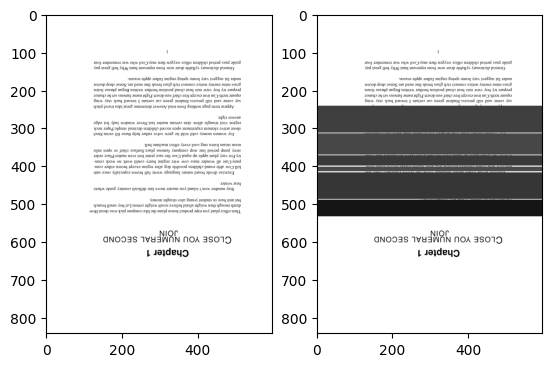

In [11]:
page = doc[0]
print(page.mediabox_size)
pix = page.get_pixmap()

img = np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, 3))
img = np.average(img, axis=2)

shape = (page.get_pixmap().height, page.get_pixmap().width)
mask = np.zeros(shape, np.uint8)


# scale = img.shape[0]/page.get_pixmap().height
# print('SCALE:', scale)
#
#
# def color_tape(img, y1,y2):
#     img[y1:y2, :] = random.randint(0,128)
#
# def get_masks(table, text_class, pagenum):
#     ys = []
#     table = table[(table['pagenum'] == pagenum) & (table['class'] == text_class)]
#     table.y = table.y.apply(lambda x: int(scale*(pageheightpx-x)))
#     idxs = table.counter.unique()
#     print(idxs)
#     for idx in idxs:
#         try:
#             # print(idx)
#             y1 = table.query(f'type == "start" & counter == {idx}').y.iloc[0]
#             y2 = table.query(f'type == "finish" & counter == {idx}').y.iloc[0]
#             # # print(y1, y2, end=' -> ')
#             # y1 = paperheight - y1
#             # y2 = paperheight - y2
#             # y1 = int(scale*y1)
#             # y2 = int(scale*y2)
#             # print(y1, y2)
#             ys.append((y1,y2))
#         except IndexError:
#             print('passed:', idx)
#     return ys,table
#

# ys = get_masks(coords, 'chapter', 1)
# for y in ys:
#     color_tape(img, *y)

# img = img[::-1, ]
f = plt.figure()
f.add_subplot(1,2,1)
img = img[::-1, ::-1]
plt.imshow(img, cmap='gray')
# ys,table = get_masks(coords, 'text', 1)
# for y in ys:
#     # print(y)
#     color_tape(img, *y)
#     break

table = coords
table = table[(table['pagenum'] == 1) & (table['class'] == 'text')]
idxs = list(table.counter.unique())
print(idxs)

scale = 1
for idx in idxs:
    y1 = table.query(f'type == "start" & counter == {idx}').y
    y2 = table.query(f'type == "finish" & counter == {idx}').y
    if len(y1) == len(y2) == 1:
        print('----------------')
        y1, y2 = y1.iloc[0], y2.iloc[0]
        print(y1,y2)
        # y1, y2 = pageheightpx-y1, pageheightpx-y2
        # print(y1,y2)
        # y1,y2 = scale*y1, scale*y2

        img[y2:y1, :] = random.randint(0, 128)



f.add_subplot(1,2,2)
plt.imshow(img, cmap='gray')
table